# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
# helper functions
import os
import skimage.io
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [2]:
data_base_path = os.path.join(os.curdir, 'project-data')
images_folder = 'images/'
annotations_folder = 'annotations/'

train_folder = 'train/'
test_folder = 'test/'
validation_folder = 'validation/'


image_train_path = os.path.join(data_base_path, images_folder+train_folder)
image_test_path = os.path.join(data_base_path, images_folder+test_folder)
image_validation_path = os.path.join(data_base_path, images_folder+validation_folder)

annotation_train_path = os.path.join(data_base_path, annotations_folder+train_folder)
annotation_test_path = os.path.join(data_base_path, annotations_folder+test_folder)
annotation_validation_path = os.path.join(data_base_path, annotations_folder+validation_folder)


with open(data_base_path+'/train.txt') as f:
    names_train = [i.strip('\n') for i in f.readlines()]
    
with open(data_base_path+'/test.txt') as f:
    names_test = [i.strip('\n') for i in f.readlines()]

with open(data_base_path+'/validation.txt') as f:
    names_validation = [i.strip('\n') for i in f.readlines()]

image_train_filenames = [os.path.join(image_train_path, name) + '.jpg' for name in names_train]
image_test_filenames = [os.path.join(image_test_path, name) + '.jpg' for name in names_test]
image_validation_filenames = [os.path.join(image_validation_path, name) + '.jpg' for name in names_validation]

In [3]:
# load annotations and images
annotations_train = [parse_file(os.path.join(annotation_train_path, name) + '.xml') for name in names_train]
annotations_test = [parse_file(os.path.join(annotation_test_path, name) + '.xml') for name in names_test]
annotations_validation = [parse_file(os.path.join(annotation_validation_path, name) + '.xml') for name in names_validation]

image_train = skimage.io.imread_collection(image_train_filenames)
image_test = skimage.io.imread_collection(image_test_filenames)
image_validation = skimage.io.imread_collection(image_validation_filenames)


In [4]:
print('Number of images/annotations in train: ', len(image_train), len(annotations_train))
print('Number of images/annotations in test: ', len(image_test), len(annotations_test))
print('Number of images/annotations in validation: ', len(image_validation), len(annotations_validation))

Number of images/annotations in train:  800 800
Number of images/annotations in test:  50 50
Number of images/annotations in validation:  150 150


## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

In [5]:
def detect_by_segmentation(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [6]:
#Your code

## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

### Proposed Methods
I proposed some methods to extract feature from each image patch.

<input type='checkbox'></input> HOG: doesnot work, because the image is very small, and the method of HOG is very sensitive with the noise.

<input type='checkbox'></input> Moment

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import moments_hu, moments, moments_central, moments_normalized
from sklearn.feature_extraction import image
from sklearn import svm
from skimage.filters import threshold_otsu
from skimage import transform
from skimage.util.shape import view_as_windows
from skimage.morphology import dilation, erosion, opening, closing, square
from scipy.ndimage import morphology
plt.rcParams['figure.figsize'] = [17, 7]
import warnings
warnings.filterwarnings('ignore')

### Proprecessing

In [8]:
def varroa_thresholding(input_image):
    
    # Transforming the image to HSV format to find the mean of lightness of image
    image_hsv = cv2.cvtColor(input_image,cv2.COLOR_RGB2HSV)
    mean_hsv = np.mean(image_hsv[:,:,2])
    
    # Improving the lightness based on the mean lightness of the image (if it is not decent)
    if (mean_hsv <= 110):
        image_hsv[:,:,2] = image_hsv[:,:,2] *1.2
    elif(mean_hsv > 150):
        image_hsv[:,:,2] = image_hsv[:,:,2] *0.8
    
    # Performing an adaptive thresholding on the grayscale version of image
    image_rgb = cv2.cvtColor(image_hsv,cv2.COLOR_HSV2RGB)
    image_grayscale = cv2.cvtColor(image_rgb,cv2.COLOR_RGB2GRAY)
    image_thresholded= ~(cv2.adaptiveThreshold(image_grayscale,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,15,3))
    
    # Performing different morphological operations to improve the result
    image_processed = skimage.morphology.remove_small_objects(image_thresholded.astype(bool), min_size=300)
    image_processed = skimage.morphology.binary_opening(image_processed.astype(bool), selem = square(4), out=None)
    image_processed = skimage.morphology.binary_closing(image_processed.astype(bool), selem = square(5), out=None)
    image_processed = skimage.morphology.binary_erosion(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.binary_dilation(image_processed.astype(bool), selem=np.ones([6,6]))
    image_processed = skimage.morphology.remove_small_objects(image_processed.astype(bool), min_size=230)
    image_processed = skimage.morphology.binary_opening(image_processed, selem = square(6), out=None)
    image_processed = morphology.binary_fill_holes(image_processed).astype(np.uint8)
    
    return image_processed

###### Show images

In [9]:
def plotAnnoOnImg(img, anno):
    fig, ax = plt.subplots(1,2)
    img_process = varroa_thresholding(img)
    for an in anno:
        rect = patches.Rectangle((an['bbox'][0], an['bbox'][1]), an['bbox'][2], an['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
#         ax[0].add_patch(rect)
        ax[1].add_patch(rect)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(img_process)
    plt.show()

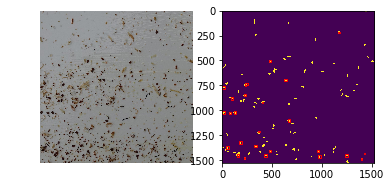

In [10]:
plotAnnoOnImg(image_train[1], annotations_train[1])

##### helper functions

In [11]:
def generateSampleImg(img, anno):
    """
        Get the part of image from the original images and the tags
    """
    annoImg = []
#     [x_1, y_1, w_1, h_2]
    for an in anno:
        x = an['bbox'][0]
        y = an['bbox'][1]
        w = an['bbox'][2]
        h = an['bbox'][3]
        img_select = img[y:y+h, x:x+w]
        moment_select = cv2.moments(img_select)
        img_center = np.array([(2*y + h) // 2, (2*x + w) // 2])
        try:
            moment_center = np.array([y + moment_select['m10'] / moment_select['m00'],
                             x + moment_select['m01'] / moment_select['m00']])
        except:
            continue
        
        diff = np.int16(moment_center - img_center)
        y = np.max([y + diff[1], 0])
        x = np.max([x + diff[0], 0])
        
        img_select_update = img[y:y+h, x:x+w]
        
        annoImg.append(img_select_update)
    return annoImg

In [12]:
# generate the test data
image_test_preprocess = [varroa_thresholding(img) for img in image_test]

In [13]:
image_train_preprocess = [varroa_thresholding(img) for img in image_train]

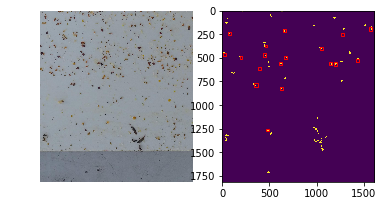

In [15]:
plotAnnoOnImg(image_test[2], annotations_test[2])

In [16]:
def IoUcalc(img):
    U = np.sum(img>0)
    I = np.sum(img==2)
    return I / U

In [17]:
def generateSamples(img, anno, blockSize, stepSize, IoU_thresh):
    """
        Generate the positive and negative samples from an image
    """
    posSamples = []
    negSamples = []
    
    if len(anno) == 0:
        return None, None

    
    imgH, imgW = np.shape(img)
    
    # fill in the anno
    imgTag = np.zeros_like(img)
    for an in anno:
        imgTag[an['bbox'][1]:an['bbox'][1]+an['bbox'][3], an['bbox'][0]:an['bbox'][0]+an['bbox'][2]] = 1
        
    for an in anno:
        y = an['bbox'][0]
        x = an['bbox'][1]
        w = an['bbox'][2]
        h = an['bbox'][3]
        
        xmin = max(x-blockSize, 0)
        ymin = max(y-blockSize, 0)
        xmax = min(x+h+blockSize, imgH)
        ymax = min(y+w+blockSize, imgW)
        
        nx = (xmax-xmin-blockSize) // stepSize
        ny = (ymax-ymin-blockSize) // stepSize
        
        imgTagPart = imgTag[xmin:xmax, ymin:ymax]
        
        for ix in range(nx):
            for iy in range(ny):
                imgWindow = np.zeros_like(imgTagPart)
                imgWindow[ix*stepSize:ix*stepSize+blockSize, iy*stepSize:iy*stepSize+blockSize] = 1
                imgCover = imgWindow + imgTagPart
                IoU_val = IoUcalc(imgCover)
                imgSelect = img[(xmin+ix*stepSize):(xmin+ix*stepSize+blockSize),(ymin+iy*stepSize):(ymin+iy*stepSize+blockSize)]
                if IoU_val > IoU_thresh and np.sum(imgSelect) > 0:
#                     plt.imshow(imgCover)
#                     plt.show()
                    posSamples.append(imgSelect)
                else:
                    negSamples.append(imgSelect)
        
        return posSamples, negSamples

In [18]:
def generateSamplesFromList(imgs, annos, blockSize, stepSize, IoU_thresh):
    posSamples = []
    negSamples = []
    
    for (img, anno) in zip(imgs, annos):
        pos, neg = generateSamples(img, anno, blockSize, stepSize, IoU_thresh)
        if pos == None or neg == None:
            continue
        posSamples.extend(pos)
        negSamples.extend(neg)
    
    return posSamples, negSamples

In [19]:
posSamples, negSamples = generateSamplesFromList(imgs=image_train_preprocess,
                                                 annos=annotations_train,
                                                 blockSize=40,
                                                 stepSize=10,
                                                 IoU_thresh=0.5)

In [20]:
print('The size of positive samples is {}'.format(len(posSamples)))
print('The size of positive samples is {}'.format(len(negSamples)))

The size of positive samples is 952
The size of positive samples is 20536


In [21]:
def generateFeature(img):
    m = moments(img)
    
    cr = m[0, 1] / m[0, 0]
    cc = m[1, 0] / m[0, 0]
    
    mu = moments_central(img, cr, cc)
    nu = moments_normalized(mu)
    hu = moments_hu(nu)
    hu[np.isnan(hu)] = 0
    hu[np.isinf(hu)] = 0
    hu = np.concatenate((hu, np.array([np.mean(img)])))
    
    return hu

In [22]:
posFeat = [generateFeature(patch) for patch in posSamples]
negFeat = [generateFeature(patch) for patch in negSamples]

In [23]:
negFeatSelect = [negFeat[ind] for ind in np.random.choice(range(len(negSamples)), size=1000)]

In [24]:
np.shape(negFeatSelect)

(1000, 8)

In [25]:
lables = np.concatenate((np.ones(len(posFeat)), np.zeros(len(negFeatSelect))))
trainData = np.concatenate((np.array(posFeat), np.array(negFeatSelect)))
# svm.SVC()

In [26]:
svmClassifier = svm.SVC()
svmClassifier.fit(trainData, lables)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [41]:
import pickle
with open('svm.pkl', 'wb') as f:
    pickle.dump(svmClassifier, f)

In [27]:
accu = svmClassifier.predict(np.array(trainData))
# svmClassifier.verbose
np.mean(accu == lables)

0.8662909836065574

In [28]:
def findCont(img):
    """
        input: img type: ndarray
        output: complex position of the points on the contour
    """
    contour = cv2.findContours(img, 
                               cv2.RETR_EXTERNAL, 
                               cv2.CHAIN_APPROX_NONE)[0]
    
    contour = max(contour, key=cv2.contourArea)
    plt.scatter(contour[:,:,0], contour[:,:,1])
    plt.imshow(img)
    contRes = contour[:,0,0] + 1j*contour[:,0,1]
    return contRes

In [29]:
def contourFourier(img):
    """
        input: images type: list
                mode: int
        output: Fourier transform of the contour
    """
    u_k = findCont(img)
            
    y_l = np.fft.fft(u_k)
    y_l_shift = np.fft.fftshift(y_l)
    f_descriptor = np.abs(y_l)[1:3]
    
    return f_descriptor

##### Evaluate of Moment+SVM

In [30]:
def centerornot(patch):
    a = cv2.moments(patch)
    
    xg = a['m01'] // a['m00']
    yg = a['m10'] // a['m00']
    
    h,w = np.shape(patch)
    
    return np.abs(h//2 - xg) + np.abs(w//2 - yg)

In [31]:
def getGcenter(patch):
    a = cv2.moments(patch)
    xg = a['m01'] // a['m00']
    yg = a['m10'] // a['m00']
    
    return (xg, yg)

In [33]:
def combineWindows(img_pos,img):
    img_record = img.copy()
    
    block_area = []

    for block in img_pos:
        x = block[0]
        y = block[1]
        h = block[2]
        w = block[3]
        (xg, yg) = getGcenter(img[x:x+h, y:y+w])
        
        if len(block_area) == 0:
            block_area.append([[block],(x+xg, y+yg)])
            continue
        flag = 1
        for block_record in block_area:
            if np.abs(x+xg - block_record[1][0]) + np.abs(y+yg-block_record[1][1]) < 30:
                block_record[0].append(block)
                x_ = []
                y_ = []
                for b in block_record[0]:
                    c_ = getGcenter(img[b[0]:b[0]+b[2], b[1]:b[1]+b[3]])
                    x_.append(b[0]+c_[0])
                    y_.append(b[1]+c_[1])
                block_record[1] = (np.mean(x_), np.mean(y_))
                flag = 0
        if flag:
            block_area.append([[block],(x+xg, y+yg)])
        
    res = []
    for block_record in block_area:
        temp = block_record[0]
        temp_sort = sorted(temp, key=lambda x: centerornot(img[x[0]:x[0]+x[2], x[1]:x[1]+x[3]]))
        res.append(temp_sort[0])
    
    return res

In [34]:
def IoUperBlock(img, blocks, gtblock, verbose=0):
    """
        Input:
            img: np.darray
            blocks: list of the prediction ground
            gtblock: groundTruth
        return: IoU value
    """
    
    width, height = np.shape(img)

    res = []
    resBlock = []
    for block in blocks:
        imgOri = np.zeros_like(img)
        imggt = np.zeros_like(imgOri)
        
        minr = block[0]
        minc = block[1]
        maxr = min(block[0]+block[2], width)
        maxc = min(block[1]+block[3], height)
        
        imgOri[minr:maxr, minc:maxc] = 1

        imggt[gtblock['bbox'][1]:gtblock['bbox'][1] + gtblock['bbox'][3], gtblock['bbox'][0]:gtblock['bbox'][0] + gtblock['bbox'][2]] = 1

        imgol = imggt + imgOri

        sizeI = np.sum(imgol == 2)
        sizeU = np.sum(imgol == 1) + np.sum(imgol == 2)
        if sizeI > 0:
            if verbose:
                print('IoU is %f' % (sizeI / sizeU))
                plt.imshow(imgol)
                plt.show()
            res.append(sizeI/sizeU)
            resBlock.append(block)
    
    if res:
        return resBlock[np.argmax(res)], np.max(res)
    
    return None, 0.0

In [45]:
def detect_by_method_1(img, img_origin, blockSize, stepSize, anno):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    
    Height, Width = np.shape(img)
    # check whether the area has been checked or not (later this can be optimized by using the probability)
    img_record = np.zeros_like(img)
#     patches = []
    img_patches = view_as_windows(arr_in=img, window_shape=(blockSize, blockSize), step=stepSize)
    img_records = {(i, j):img_patches[i,j] for i in range(np.shape(img_patches)[0]) for j in range(np.shape(img_patches)[1])}
    
#     print(len(img_records))
    def check(small_patch):
        if svmClassifier.predict(generateFeature(small_patch).reshape(1,-1))[0]:
            return True
        return False
    
    img_filter = list(filter(lambda x: check(x[1]), img_records.items()))
    
    img_positions = [[img_block[0][0]*stepSize, img_block[0][1]*stepSize, blockSize, blockSize] for img_block in img_filter]
#     print(len(img_positions))
    img_positions = combineWindows(img_positions, img)
#     print(len(img_positions))
    fig, ax = plt.subplots(1,1)
    

    block_record = []
    for an in anno:
        block, iou_val = IoUperBlock(img, img_positions, an)
        if iou_val >= 0.3:
            rect = patches.Rectangle((block[1], block[0]), block[3], block[2],
                linewidth=0.5,edgecolor='g',facecolor='none')
            ax.add_patch(rect)
            block_record.append(block)
            
    
    for img_block in img_positions:
        if img_block not in block_record:
            rect = patches.Rectangle((img_block[1], img_block[0]), img_block[3], img_block[2],
                    linewidth=0.5,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
    
    for an in anno:
        rect = patches.Rectangle((an['bbox'][0], an['bbox'][1]), an['bbox'][2], an['bbox'][3],
                linewidth=1,edgecolor='black',facecolor='none')
    #         ax[0].add_patch(rect)
        ax.add_patch(rect)
    precision = 0.0
    recall = 0.0
    F1 = 0.0
    
    if len(img_positions) > 0:
        precision = len(block_record) / len(img_positions)
    
    if len(anno) > 0:
        recall = len(block_record) / len(anno)
    
    if precision + recall > 0:
        F1 = 2 * (precision * recall) / (precision + recall)
    ax.set_title('Precision: %.4f Recall: %.4f, F1-score: %.4f' % (precision, recall, F1))
    ax.imshow(img_origin)
    plt.show()
    

    return img_filter

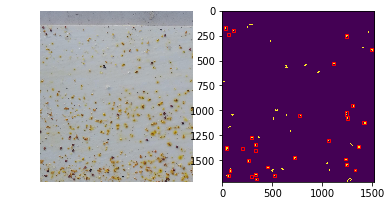

In [46]:
plotAnnoOnImg(image_test[7], annotations_test[7])

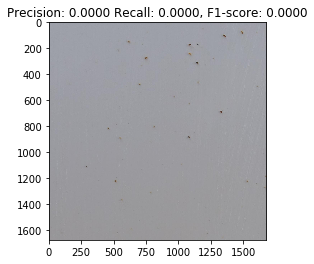

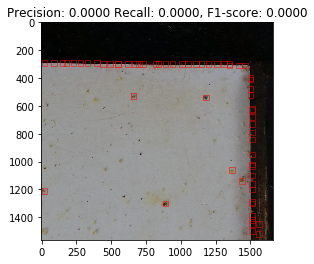

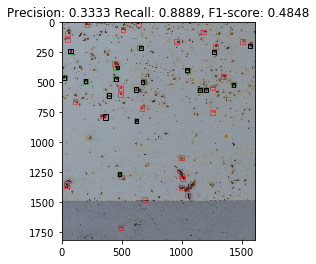

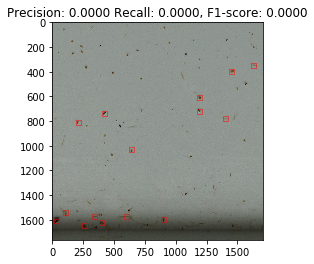

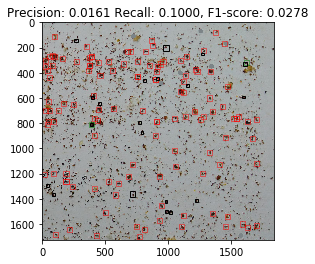

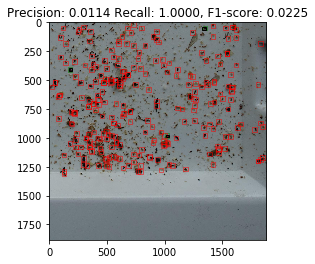

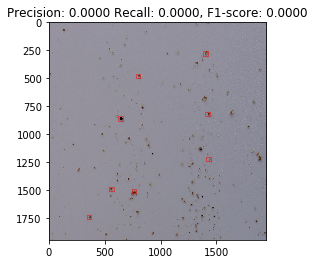

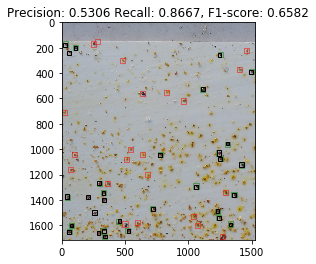

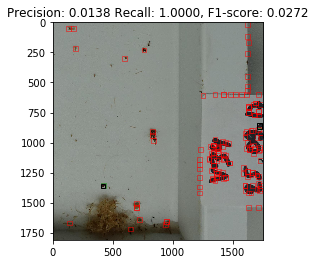

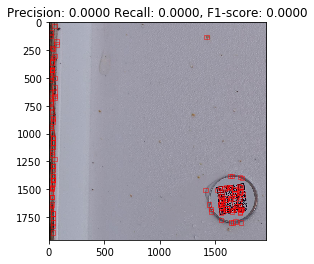

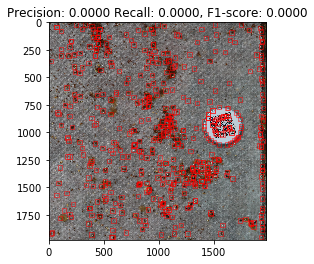

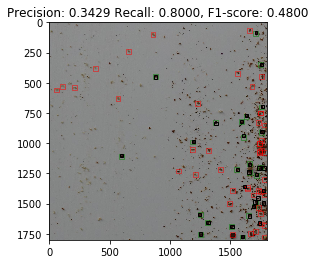

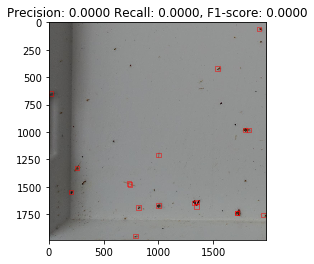

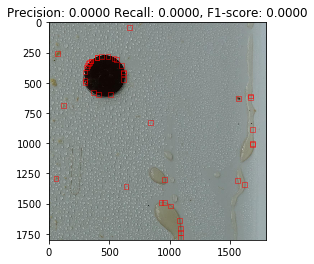

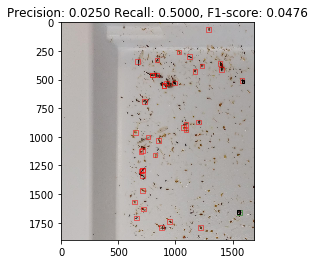

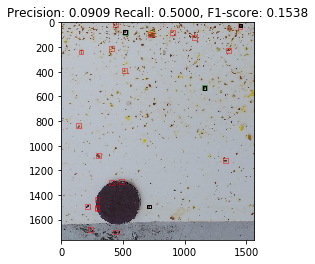

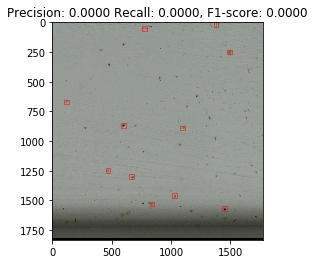

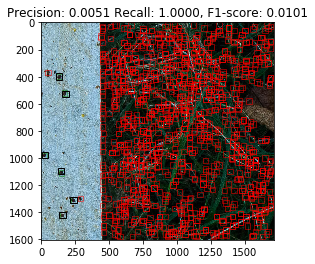

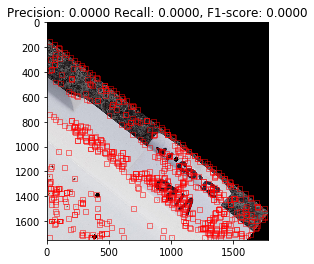

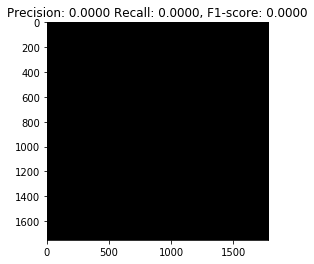

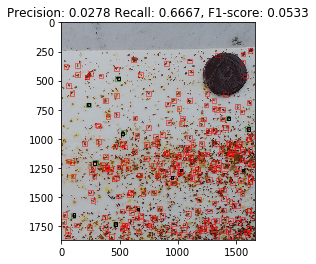

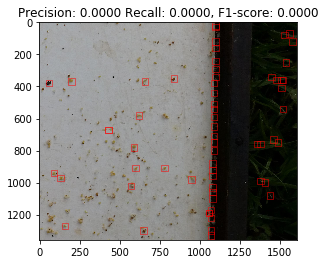

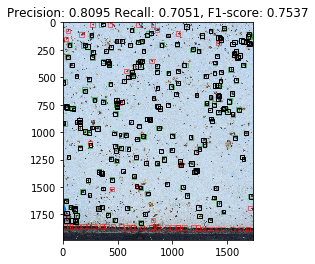

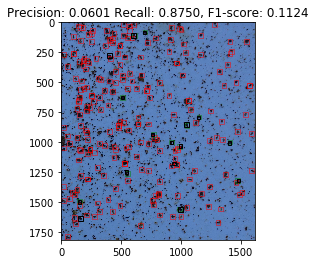

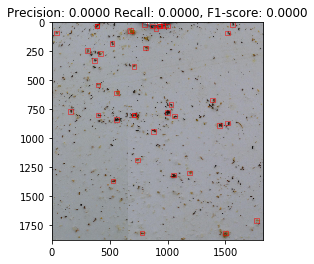

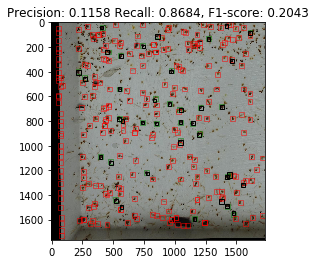

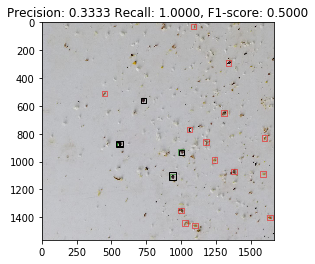

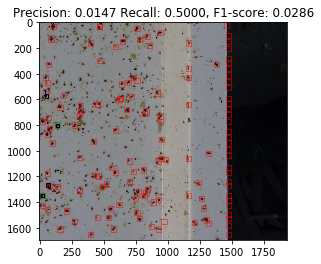

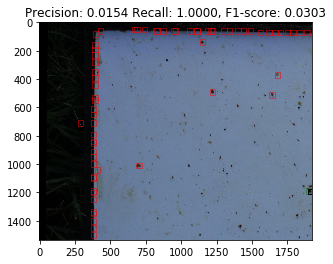

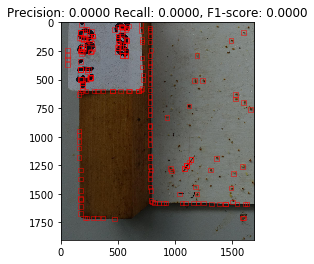

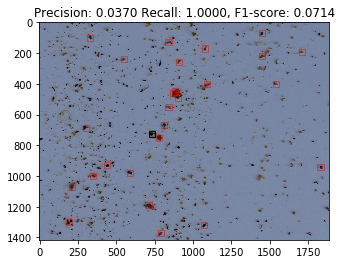

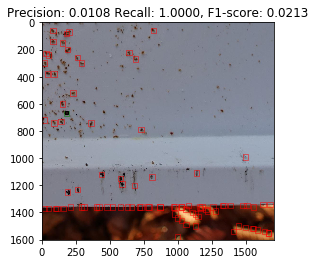

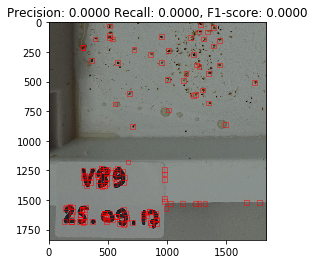

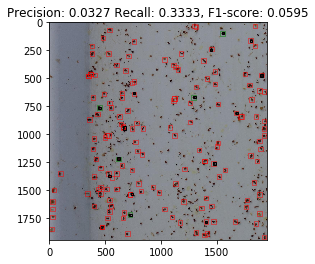

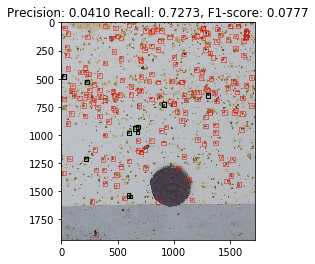

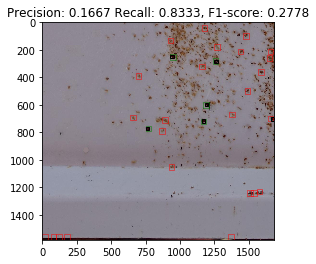

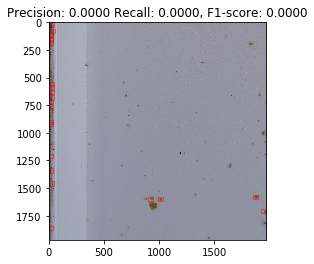

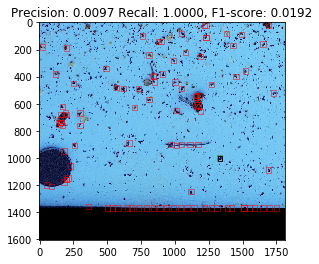

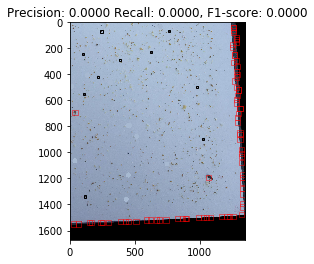

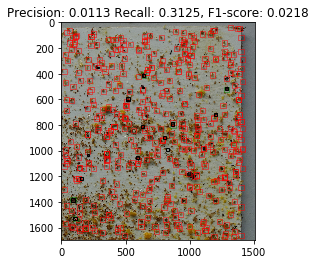

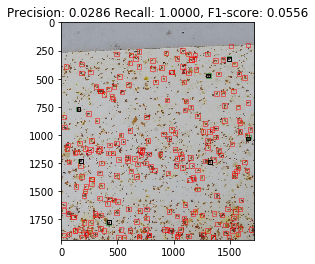

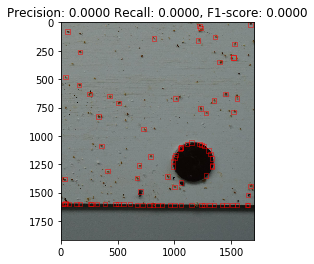

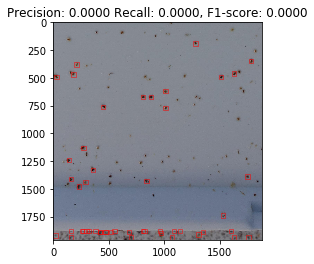

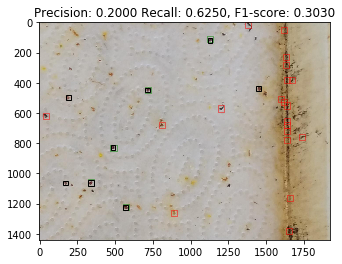

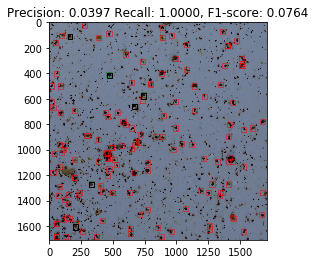

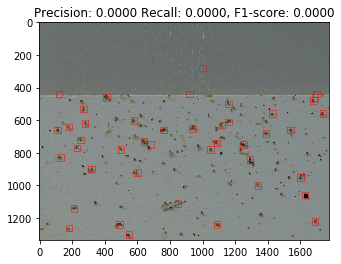

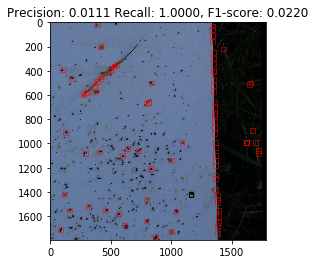

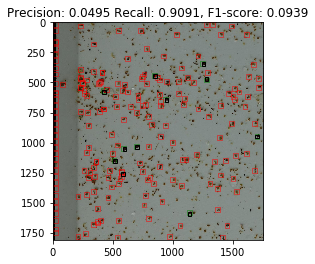

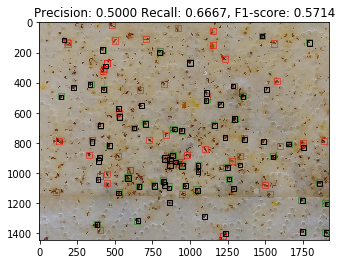

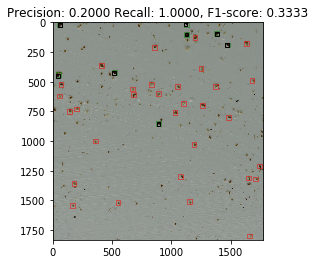

In [47]:
for i in range(len(image_test_preprocess)):
    detect_by_method_1(img=image_test_preprocess[i], img_origin=image_test[i], blockSize=40, stepSize=10, anno=annotations_test[i])

###### Reflection:
1. very slow:<br>
    a. Reason1: step is 1 which is meaning less <br>
    b. Reason2: can actually skip to next one if the current one is satisfied <br>
    c. Reason3: SVM can be simplier as no big differences whether augmented or not <br>
    d. Reason4: before svm, we can add another checker

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [4]:
#Your code

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

### First Methods: Slider windows with better classifier

In [110]:
def generateColorSamples(img, anno, blockSize, stepSize):
    # here, we suppose that the stepSize == blockSize
    pos = []
    neg = []
    if len(anno) == 0:
        return pos, neg

    # here, as the img has three channels, we decide no use view_windows function
    H, W, _ = np.shape(img)
    nH = H // stepSize
    nW = W // stepSize
    
    img_record = []
    for iH in range(nH):
        for iW in range(nW):
            centerX = iH*stepSize + blockSize//2
            centerY = iW*stepSize + blockSize//2
            minx = iH*stepSize
            miny = iW*stepSize
            maxx = iH*stepSize + blockSize
            maxy = iW*stepSize + blockSize
            
            img_record.append([centerX, centerY, img[minx:maxx, miny:maxy, :]])
    
    anno_record = []
    for an in anno:
        annoCenterX = an['bbox'][1] + an['bbox'][3]//2
        annoCenterY = an['bbox'][0] + an['bbox'][2]//2
        anno_record.append([annoCenterX, annoCenterY])
        
    ind_record = []
    for anCenter in anno_record:
        img_dist = np.zeros(len(img_record))
        for img_ind in range(len(img_record)):
            img_dist[img_ind] = np.square(img_record[img_ind][0] - anCenter[0]) + np.square(img_record[img_ind][1] - anCenter[1])
        tmp_record = np.argmin(img_dist)
        ind_record.append(tmp_record)
        pos.append(img_record[tmp_record][2])
        
    for ind in range(len(img_record)):
        if ind not in ind_record:
            neg.append(img_record[ind][2])
    
    return pos, neg

In [113]:
def generateColorSamplesAll(imgs, annos, blockSize, stepSize):
    poss = []
    negs = []
    count = 0
    for (img, anno) in zip(imgs, annos):
        count += 1
        print('=====Generate %s =========' % str(count))
        pos, neg = generateColorSamples(img, anno, blockSize, stepSize)
        poss.extend(pos)
        negs.extend(neg)
    
    return poss, negs

In [114]:
poss, negs = generateColorSamplesAll(image_train, annotations_train, 40, 20)

=====Generate 1 =========
=====Generate 2 =========
=====Generate 3 =========
=====Generate 4 =========
=====Generate 5 =========
=====Generate 6 =========
=====Generate 7 =========
=====Generate 8 =========
=====Generate 9 =========
=====Generate 10 =========
=====Generate 11 =========
=====Generate 12 =========
=====Generate 13 =========
=====Generate 14 =========
=====Generate 15 =========
=====Generate 16 =========
=====Generate 17 =========
=====Generate 18 =========
=====Generate 19 =========
=====Generate 20 =========
=====Generate 21 =========
=====Generate 22 =========
=====Generate 23 =========
=====Generate 24 =========
=====Generate 25 =========
=====Generate 26 =========
=====Generate 27 =========
=====Generate 28 =========
=====Generate 29 =========
=====Generate 30 =========
=====Generate 31 =========
=====Generate 32 =========
=====Generate 33 =========
=====Generate 34 =========
=====Generate 35 =========
=====Generate 36 =========
=====Generate 37 =========
=====Gener

=====Generate 298 =========
=====Generate 299 =========
=====Generate 300 =========
=====Generate 301 =========
=====Generate 302 =========
=====Generate 303 =========
=====Generate 304 =========
=====Generate 305 =========
=====Generate 306 =========
=====Generate 307 =========
=====Generate 308 =========
=====Generate 309 =========
=====Generate 310 =========
=====Generate 311 =========
=====Generate 312 =========
=====Generate 313 =========
=====Generate 314 =========
=====Generate 315 =========
=====Generate 316 =========
=====Generate 317 =========
=====Generate 318 =========
=====Generate 319 =========
=====Generate 320 =========
=====Generate 321 =========
=====Generate 322 =========
=====Generate 323 =========
=====Generate 324 =========
=====Generate 325 =========
=====Generate 326 =========
=====Generate 327 =========
=====Generate 328 =========
=====Generate 329 =========
=====Generate 330 =========
=====Generate 331 =========
=====Generate 332 =========
=====Generate 333 ==

=====Generate 592 =========
=====Generate 593 =========
=====Generate 594 =========
=====Generate 595 =========
=====Generate 596 =========
=====Generate 597 =========
=====Generate 598 =========
=====Generate 599 =========
=====Generate 600 =========
=====Generate 601 =========
=====Generate 602 =========
=====Generate 603 =========
=====Generate 604 =========
=====Generate 605 =========
=====Generate 606 =========
=====Generate 607 =========
=====Generate 608 =========
=====Generate 609 =========
=====Generate 610 =========
=====Generate 611 =========
=====Generate 612 =========
=====Generate 613 =========
=====Generate 614 =========
=====Generate 615 =========
=====Generate 616 =========
=====Generate 617 =========
=====Generate 618 =========
=====Generate 619 =========
=====Generate 620 =========
=====Generate 621 =========
=====Generate 622 =========
=====Generate 623 =========
=====Generate 624 =========
=====Generate 625 =========
=====Generate 626 =========
=====Generate 627 ==

In [115]:
print('The number of positive patches is {}'.format(len(poss)))
print('The number of negative patches is {}'.format(len(negs)))

The number of positive patches is 7483
The number of negative patches is 3814948


In [155]:
with open('posSample.pkl', 'wb') as f:
    pickle.dump([poss, neg_select], f)

In [117]:
# select the equal number of patches for the negative
neg_ind = np.random.choice(len(negs), len(poss))
neg_select = [negs[ind] for ind in neg_ind]

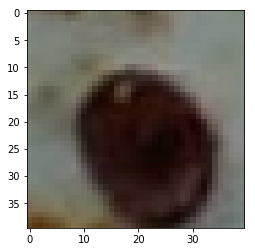

In [135]:
plt.imshow(poss[29])

### Think later whether we need augmentation

In [146]:
import tensorflow as tf

learning_rate = 1e-3
training_steps = 50
batch_size = 128
display_step = 10

conv1_kernel = 10
conv2_kernel = 20
conv1_filter = 32
conv2_filter = 64
fc_unit = 1024
dropout = 0.2

In [152]:
def conv_net(x):
    with tf.variable_scope('ConvNet'):
        x = tf.reshape(x['images'], shape=[-1,40,40,3])
        
        conv1 = tf.layers.conv2d(x,
                                 conv1_filter,
                                 conv1_kernel,
                                 padding='same',
                                 activation=tf.nn.relu)
        
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)
        
        conv2 = tf.layers.conv2d(conv1,
                                 conv2_filter,
                                 conv2_kernel,
                                 padding='same',
                                 activation=tf.nn.relu)
        
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        fc1 = tf.contrib.layers.flatten(conv2)
        
        fc1 = tf.layers.dense(fc1, fc_unit)
        
        # add dropout
        fc1 = tf.layers.dropout(fc1, rate=dropout)
        
        out = tf.layers.dense(fc1, 1)
    
    return out

In [153]:
def model_fn(features, labels, mode):
    
    train_result = conv_net(features)
    
    train_labels = tf.nn.sigmoid(train_result)
    
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(labels, dtype=tf.int32),
                                                                     logits=train_result))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    acc_op = tf.metrics.accuracy(labels=labels, predictions=train_labels)
    
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=train_labels,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})
    
    return estim_specs

In [154]:
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/wv/n59q616x4_b_yvm_h7ny204w0000gn/T/tmp6kycc2z6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1cd29a7be0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [170]:
clean_poss = [p for p in poss if p.shape == (40,40,3)]

In [172]:
len(clean_poss)

7430

In [ ]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': }, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [6]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [7]:
#Your code